In [1]:
# ------------------------------------------
# IMPORT AND SETUP
# ------------------------------------------

import sys, os
from pathlib import Path
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))) # This construct was reworked with the assistance of AI (DeepSeek) 

#Import the various classes from the src files
from data_import import RawData
raw_data = RawData()

from data_handling import RefinedData
ref_data = RefinedData()

from utils import VisualTable
pretty_table = VisualTable()

from analysis import AnalysedData
analysed_data = AnalysedData()

from graphs import Graphs
graphic_data = Graphs()

# ------------------------------------------
# VARIABLES
# ------------------------------------------
    
# Frost API Settings for retrieving weather data
FROST_API_CONFIG = {
    'station_id': 'SN68860',  # Weather station ID, can be multiple stations separated by a comma - 'SN68860' is Voll weatherstation
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)', # The measurements to include in the dataset, here: temperautre, precipitation, and wind speed
    'time_range': '2003-08-01/2018-08-01',# The stretch of time to fetch weather data from
    'resolution': 'P1D' # The level of granularity in the weather data. P1D is once per day. P1H is once per hour.
}

# File paths
FILE_PATH = Path('../data/luftkvalitet_trondheim_15ar.csv') #Using path/PathLib was suggested by AI (DeepSeek)

# Analysis threshold
UPTIME_THRESHOLD = 95 # Minimum uptime (%) for valid air quality data

# The number of standard deviations that defines an outlier
SD_MOD = 3 # A lower number gives a higher number of outliers, recommended range is 2-3

# -- Variables for analysis and graphing
POLLUTANTS = ['CO', 'NO', 'NO2', 'NOx', 'PM10', 'PM2.5'] # The columns that can be found in the air pollutant data
WEATHER_VARS = ['temperature (C)', 'wind_speed (m/s)', 'precipitation (mm)'] # The columns that can be found in the weather data

# Y-axis limits and alignment for weather plots: [temp (C), wind (m/s), precip (mm)]
WEATHER_Y_LIMS = [(-20, 30), (0, 20), (0, 100)] 
ZERO_ALIGN = [False, True, True] # Wether to align the 0 on both y-axis or not

SHOW_ALL_TABLES = False # Shows full tables at every step if True, excluding them if False

In [2]:
# ------------------------------------------
# WEATHER DATA - IMPORT AND PROCESSING
# ------------------------------------------

# Run the module for importing the weather data, and save it to a dataframe
df_weather = raw_data.get_met(**FROST_API_CONFIG)

# The following block of code was generated by AI when the API was down temporarily
    # Purpose: Generate sample weather data that enables the program to run if the API is down
    # AI Tool: DeepSeek

# Temporary weather data for if/when the API is down
'''df_weather = pd.DataFrame({
    'referenceTime': ['2024-01-30', '2024-01-31', '2024-02-01'],
    'Temperature': [10, 15, 11],
    'Precipitation': [0, 5, 2],
    'Wind_Speed': [3, 7, 2]
})'''

# Check if data was fetched successfully and check for missing values
if df_weather is None:
    print("Failed to fetch weather data.")
else:
    # Report missing values as a dataframe
    missing_df = ref_data.missing_data(df_weather, strategy='report')
    if missing_df is not None:
        print("\nThe following datapoints are missing:")
        pretty_table.pretty_data(missing_df)

    # Fill missing values with chosen fill_value
    filled_df = ref_data.missing_data(df_weather, strategy='fill', fill_value=np.nan)
    if filled_df is not None:
        df_weather = filled_df

    if SHOW_ALL_TABLES is True:
        print('\nThe entire table of weather data:')
        pretty_table.pretty_data(df_weather)

2025-05-23 08:47:20,933 - INFO - 
Successfully collected 5479 raw observations (5479 unique timestamps) from Frost API

2025-05-23 08:47:21,090 - INFO - 
Processed DataFrame: 5479 rows x 3 parameters (99.3% non-empty values)




The following datapoints are missing:


In [3]:
# ------------------------------------------
# AIR QUALITY DATA - IMPORT AND PROCESSING
# ------------------------------------------

# Run the module for importing the air quality data, and save it to a dataframe
df_quality = raw_data.get_nilu(UPTIME_THRESHOLD, FILE_PATH)

# Check if data was fetched successfully and check for missing values
if df_quality is None:
    print("Failed to fetch weather data.")
else:
    missing_data = ref_data.missing_data(df_quality)
    if missing_data is not None:
        print("\nThe following datapoints are missing:")
        pretty_table.pretty_data(missing_data)

# Displaying the air quality data as a table
if SHOW_ALL_TABLES is True:
    print('\nThe entire table of air pollution data (pollutants are in µg/m³):')
    pretty_table.pretty_data(df_quality)

2025-05-23 08:47:21,179 - INFO - 
Successfully collected and processed 5480 rows of data from ../data/luftkvalitet_trondheim_15ar.csv

2025-05-23 08:47:21,187 - INFO - 
Processed DataFrame: 5480 rows x 6 parameters (60.2% non-empty values)




The following datapoints are missing:



Standard deviation of weather data



Standard deviation of air pollution data



Total average(mean) of weather data



Total average(mean) of air pollution data



Outliers from the weather data



Outliers from the pollution data


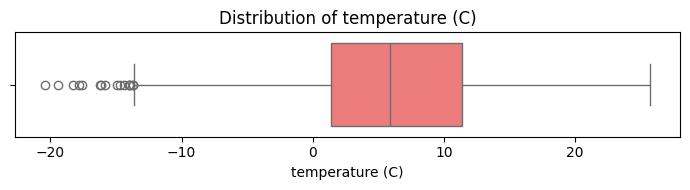

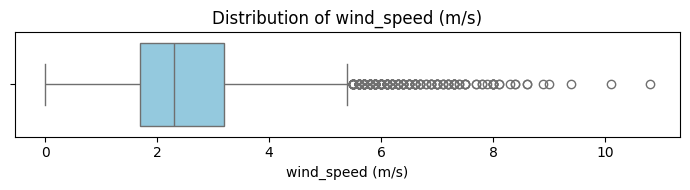

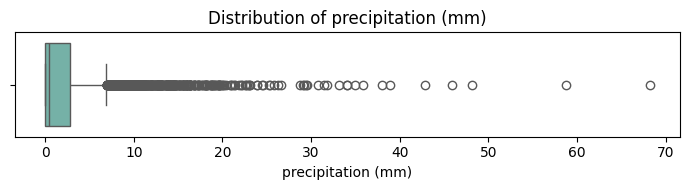

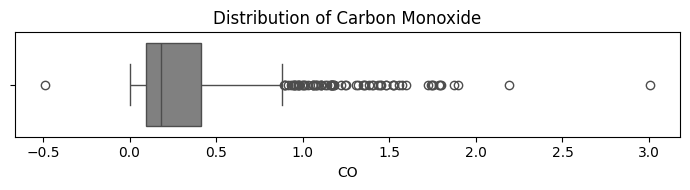

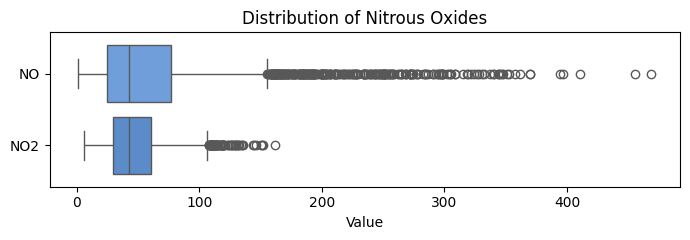

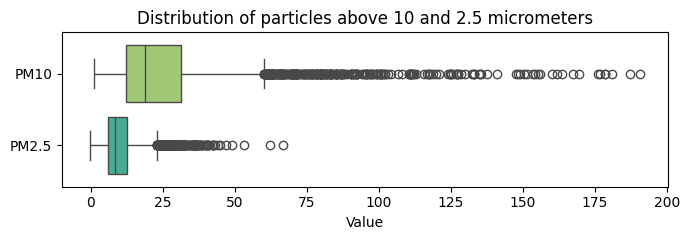

In [ ]:
# ------------------------------------------
# DATA AND PATTERN ANALYSIS
# ------------------------------------------

# Standard deviations of weather data
weather_standard_deviation = analysed_data.standard_deviation(df_weather, WEATHER_VARS)
print('\nStandard deviation of weather data')
pretty_table.pretty_data(weather_standard_deviation)

# Standard deviations of air pollutant data
pollutants_standard_deviation = analysed_data.standard_deviation(df_quality, POLLUTANTS)
print('\nStandard deviation of air pollution data')
pretty_table.pretty_data(pollutants_standard_deviation)

# Total average for weather data
weather_average = analysed_data.total_average(df_weather, WEATHER_VARS)
print('\nTotal average(mean) of weather data')
pretty_table.pretty_data(weather_average)

# Total average for pollution data
pollution_average = analysed_data.total_average(df_quality, POLLUTANTS)
print('\nTotal average(mean) of air pollution data')
pretty_table.pretty_data(pollution_average)

# Outliers of weather data
weather_outliers, weather_x_outliers = analysed_data.outliers(df_weather, WEATHER_VARS, weather_standard_deviation, weather_average, SD_MOD)
print('\nOutliers from the weather data')
pretty_table.pretty_data(weather_outliers)
if SHOW_ALL_TABLES is True:
    print('\nWeather data without outliers')
    pretty_table.pretty_data(weather_x_outliers)

#Outliers of air pollution data
pollution_outliers, pollution_x_outliers = analysed_data.outliers(df_quality, POLLUTANTS, pollutants_standard_deviation, pollution_average, SD_MOD)
print('\nOutliers from the pollution data')
pretty_table.pretty_data(pollution_outliers)
if SHOW_ALL_TABLES is True:
    print('\nPollution data without outliers')
    pretty_table.pretty_data(pollution_x_outliers)

# Averages of weather data
df_average_weather = analysed_data.averages(weather_x_outliers, WEATHER_VARS)
if SHOW_ALL_TABLES is True:
    print('\nTable of weekly averages for weather data:')
    pretty_table.pretty_data(df_average_weather)

# Averages of air pollutant data
df_average_pollutants = analysed_data.averages(pollution_x_outliers, POLLUTANTS)
if SHOW_ALL_TABLES is True:
    print('\nTable of weekly averages for air pollution (pollutants are in µg/m³):')
    pretty_table.pretty_data(df_average_pollutants)

# Box plots of weather variables
colors = ['#FF6B6B','skyblue','#6BBBAE' ]
for column, color in zip(WEATHER_VARS, colors):
    analysed_data.box_plots(
        df = df_weather,
        columns = [column],
        color = color,
        figsize = [7, 2]
    )

# Box plot of Carbon monoxide
analysed_data.box_plots(
    df = df_quality,
    columns = 'CO',
    color = 'grey',
    figsize = (7, 2),
    title = 'Distribution of Carbon Monoxide',
    x_label = 'µg/m³'
)

# Box plot of Nitrous Oxides
analysed_data.box_plots(
    df = df_quality,
    columns = ['NO', 'NO2'],
    color = ['#5D9CEC', '#3A6CB7'],
    figsize = (7,2.5),
    title = 'Distribution of Nitrous Oxides',
    x_label = 'µg/m³'
)

# Box plot of Particles
analysed_data.box_plots(
    df = df_quality,
    columns = ['PM10', 'PM2.5'],
    color = ['#A0D468', '#37BC9B'],
    figsize = (7,2.5),
    title = 'Distribution of particles above 10 and 2.5 micrometers',
    x_label = 'µg/m³'
)

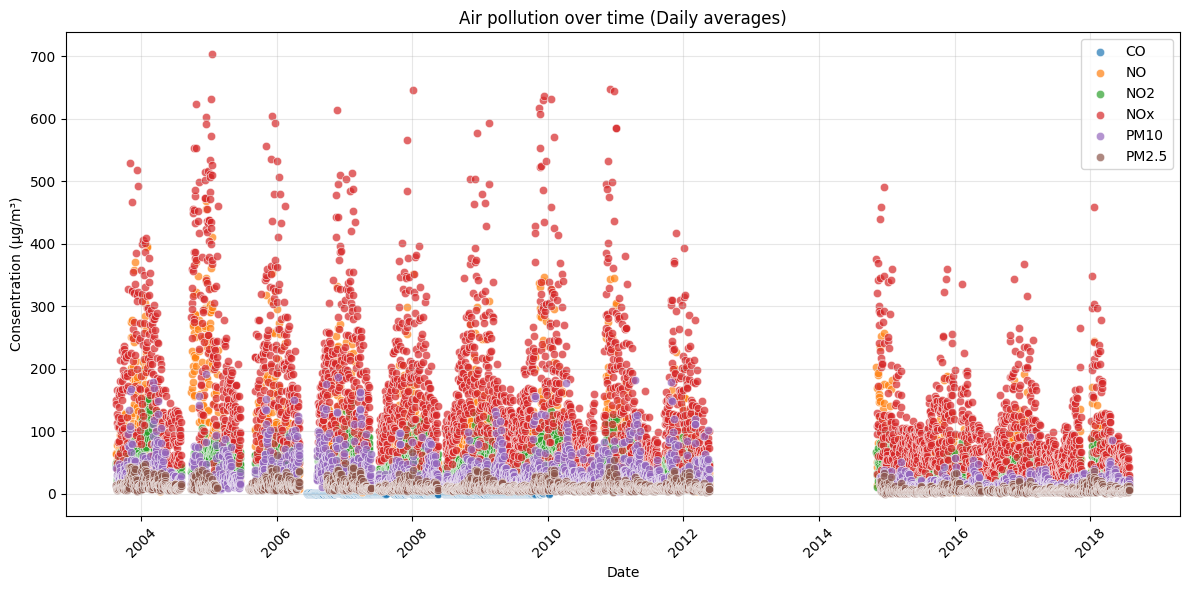

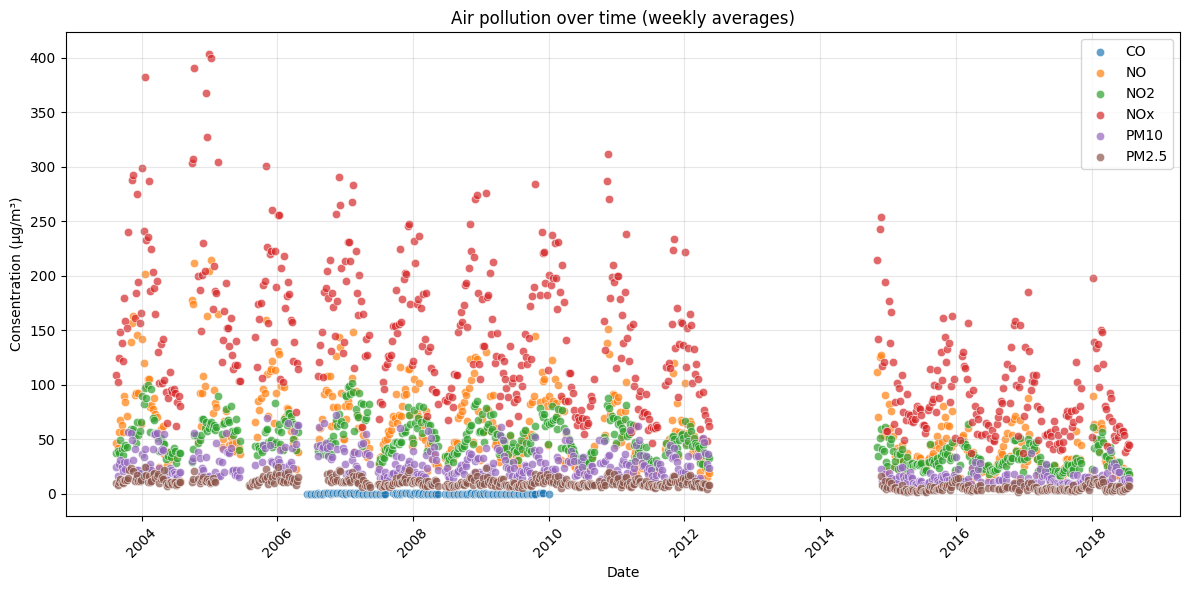

2025-05-23 08:47:26,730 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 08:47:27,362 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


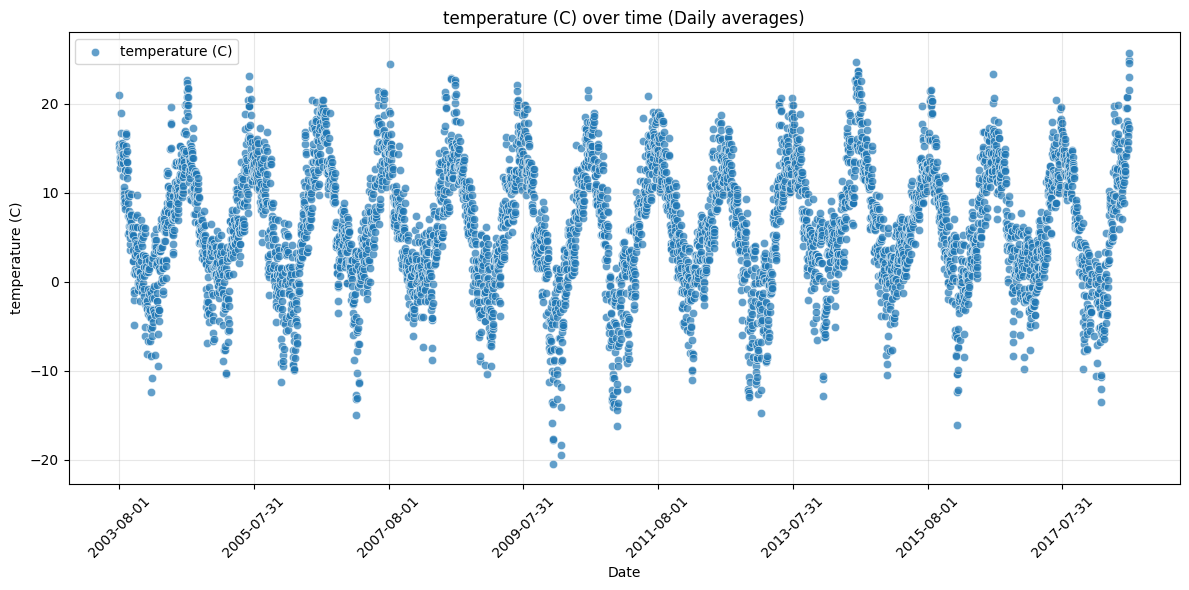

2025-05-23 08:47:37,461 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 08:47:37,841 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


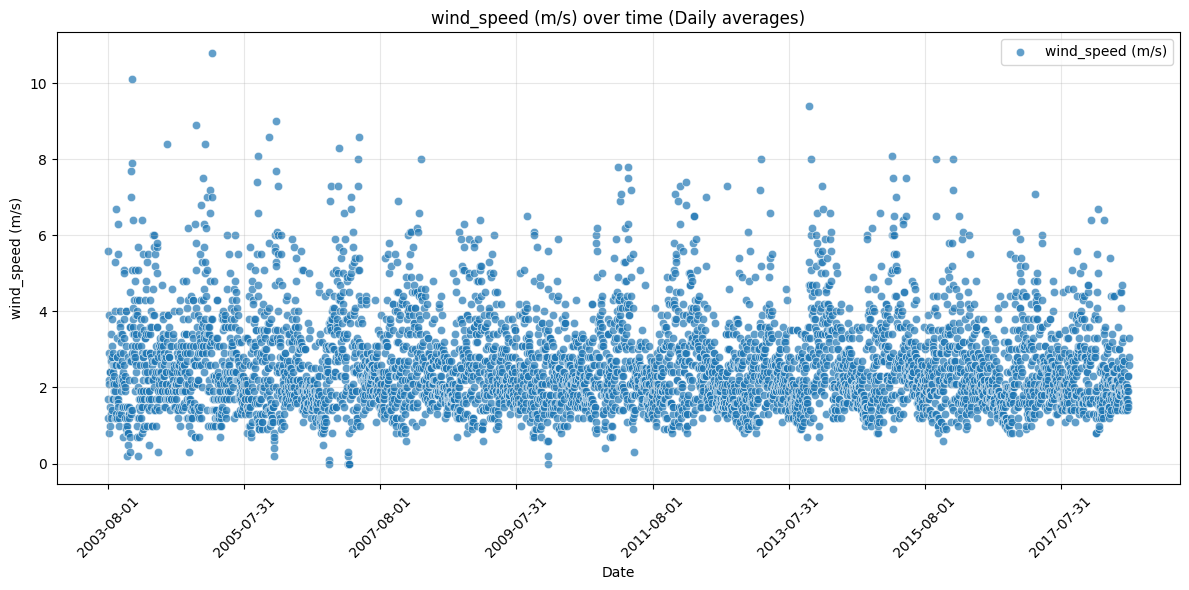

2025-05-23 08:47:47,773 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 08:47:48,090 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


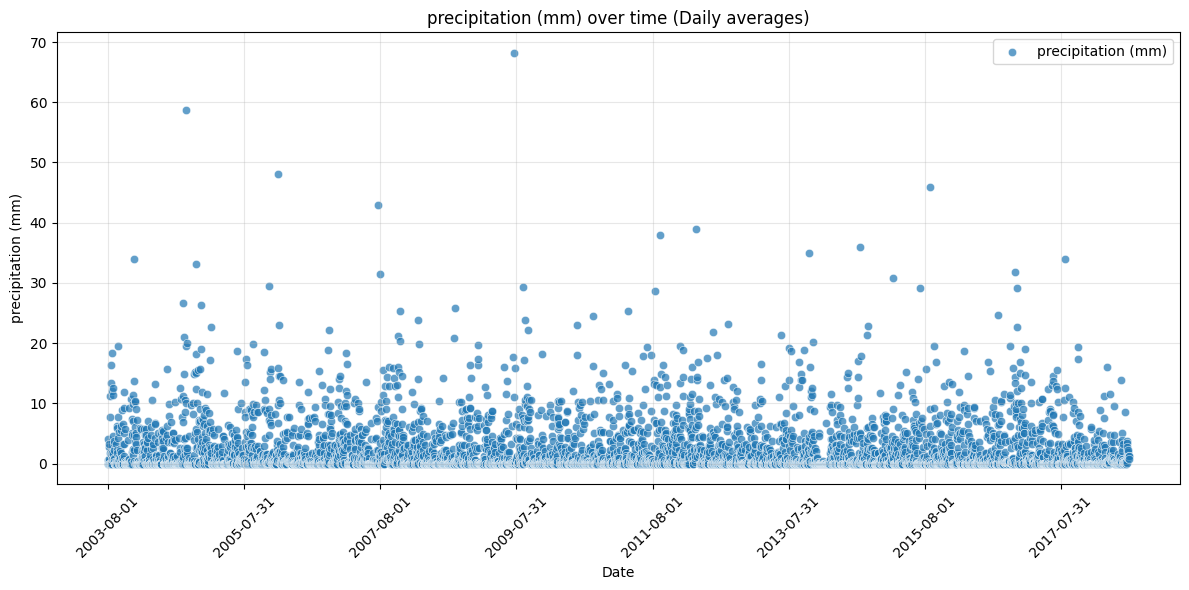

2025-05-23 08:47:57,095 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 08:47:57,148 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


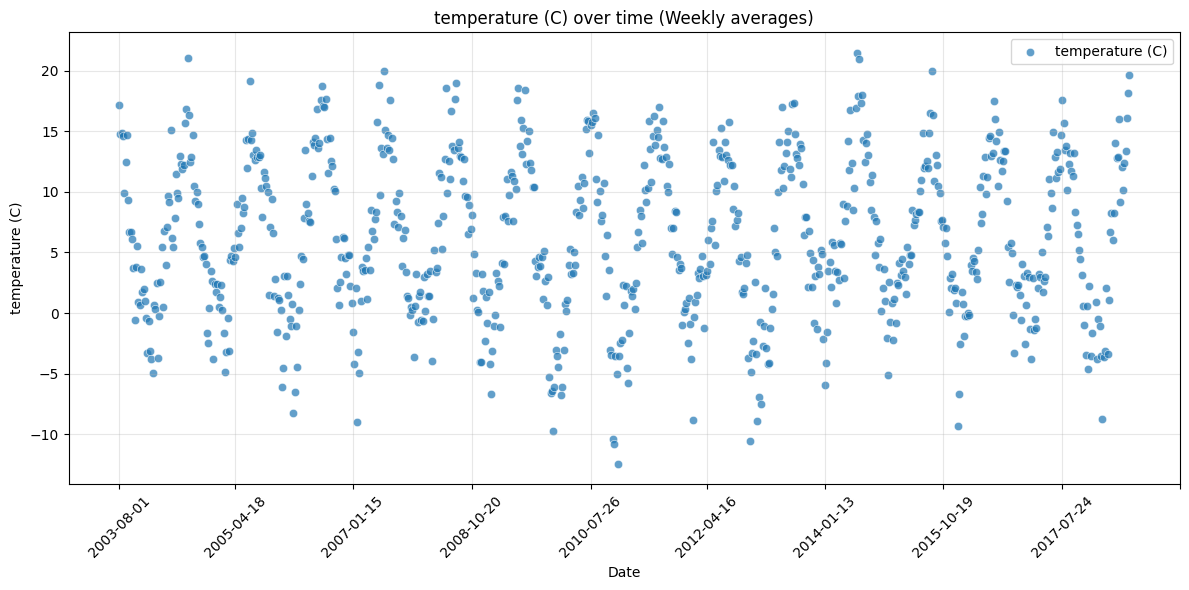

2025-05-23 08:47:59,076 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 08:47:59,135 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


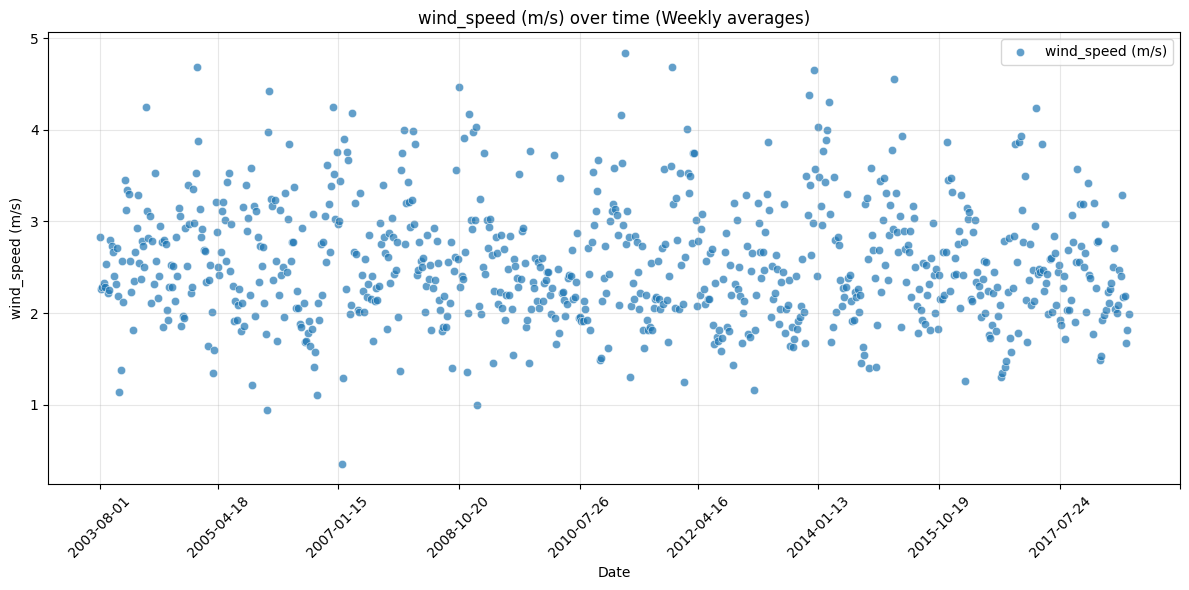

2025-05-23 08:48:01,026 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 08:48:01,079 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


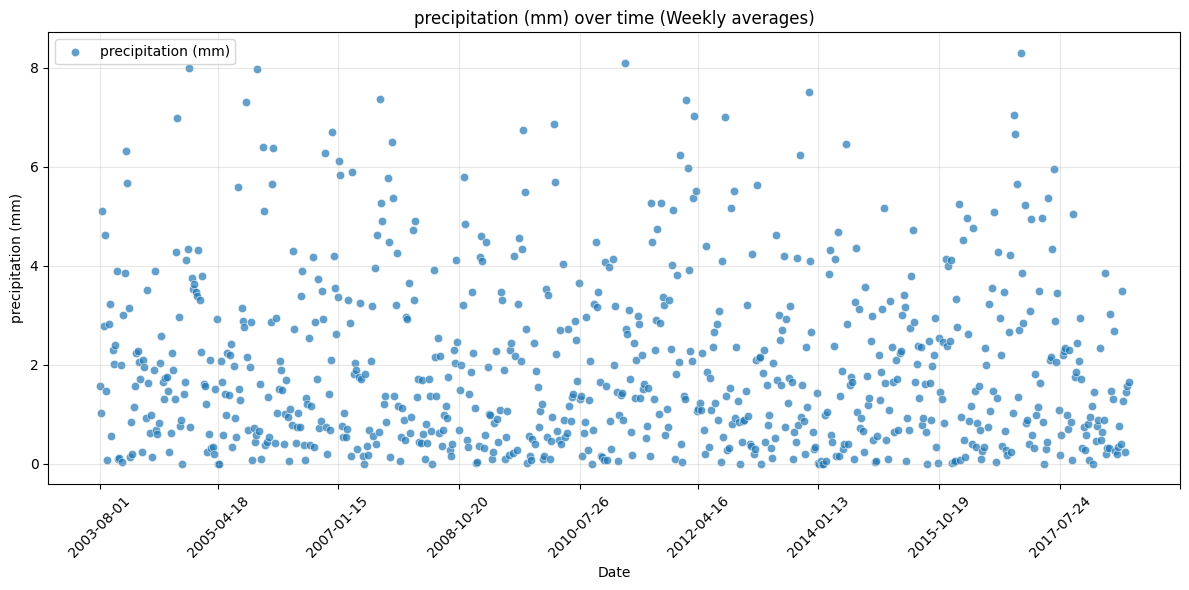

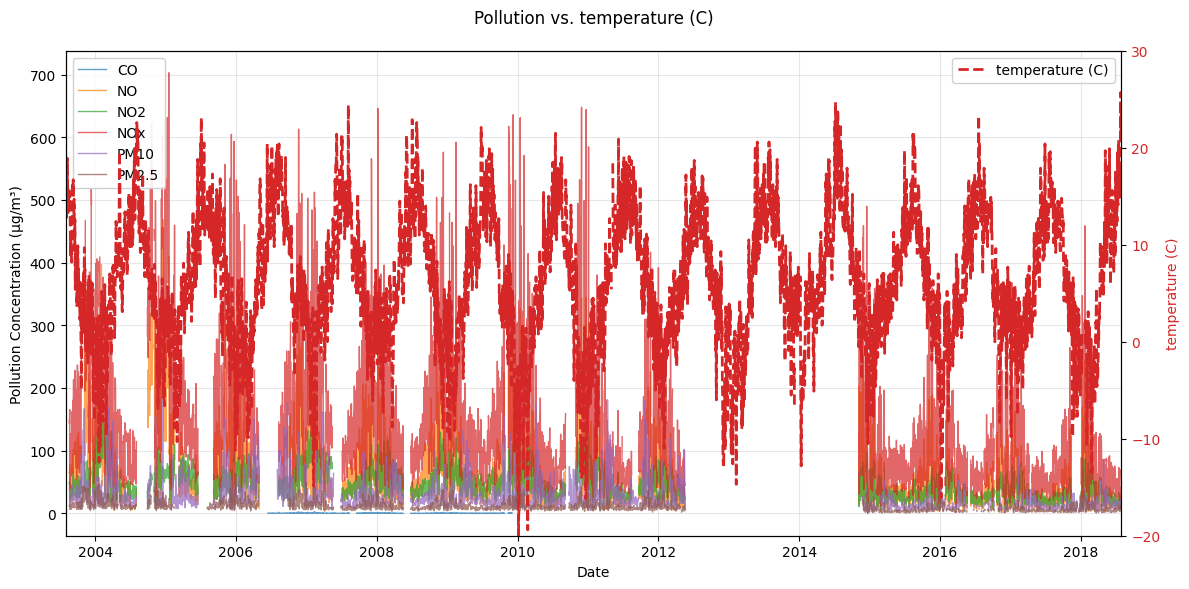

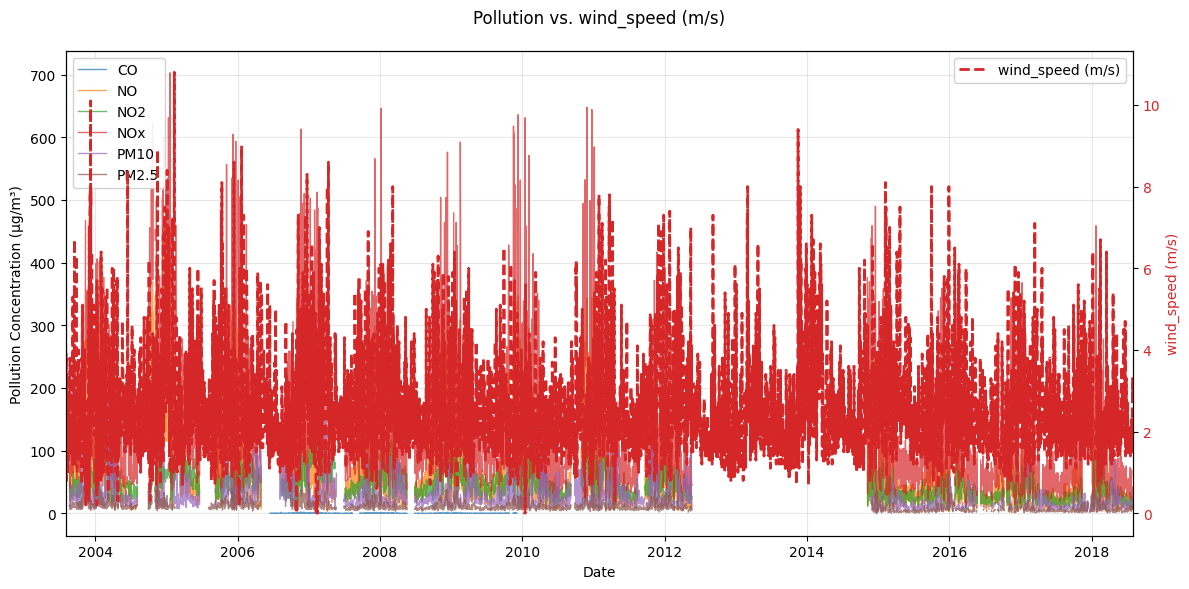

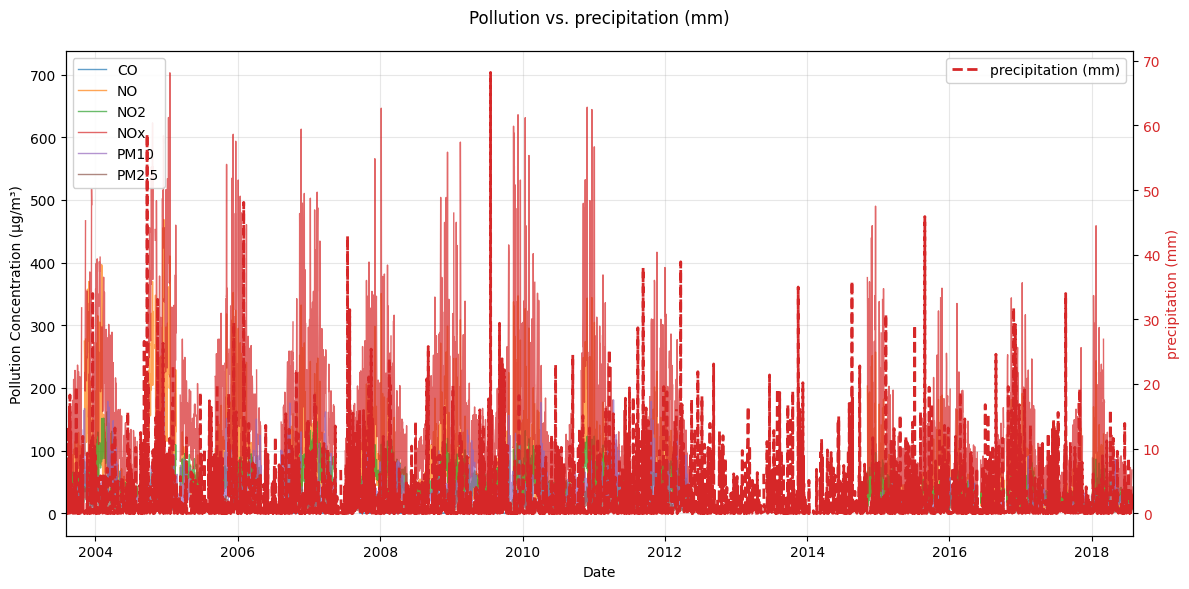

In [5]:
# ------------------------------------------
# DATA VISUALISATION AND GRAPHING
# ------------------------------------------

# Creating a sattergraph for the air quality data
graphic_data.dot_graph(df_quality, POLLUTANTS, 'Air pollution over time (Daily averages)', 'Date', 'Consentration (µg/m³)')

# Creating a scattergraph for weekly averages of air quality data
graphic_data.dot_graph(df_average_pollutants, POLLUTANTS, 'Air pollution over time (weekly averages)', 'Date', 'Consentration (µg/m³)')

# Creating a scattergraph for each of the the weather data variables
for column in WEATHER_VARS:
    graphic_data.dot_graph(
        df=df_weather,
        columns=[column],  
        title=f'{column} over time (Daily averages)', 
        x_axis='Date',
        y_axis=column  
    )

# Creating a scattergraph for each of the the weather data variables for weekly averages
for column in WEATHER_VARS:
    graphic_data.dot_graph(
        df=df_average_weather,
        columns=[column],
        title=f'{column} over time (Weekly averages)', 
        x_axis='Date',
        y_axis=column  
    )

# Creating a comparative graph of air pollutants vs one weather data variable
for predictor, y_lim, should_align in zip(WEATHER_VARS, WEATHER_Y_LIMS, ZERO_ALIGN):
    graphic_data.comparative_graph(
        df=df_quality,
        columns=POLLUTANTS, 
        df_predictor=df_weather,
        predictor=predictor,
        title=f'Pollution vs. {predictor}',  
        x_axis='Date',
        y_axis='Pollution Concentration (µg/m³)',
        y_lims=y_lim,
        zero_align=should_align
    )

In [6]:
# ------------------------------------------
# INTERACTIVE DATA VISUALIZATION
# ------------------------------------------
import plotly.io as pio
pio.renderers.default = "notebook_connected" 

from graph_test import InteractiveGraphs
ig = InteractiveGraphs(weather_vars=WEATHER_VARS)

# Daily pollution (toggle pollutants)
ig.dot_graph(df_quality, POLLUTANTS, 'Air pollution (Daily)', 'Date', 'Concentration (µg/m³)')

# Weekly pollution (toggle pollutants)
ig.dot_graph(df_average_pollutants, POLLUTANTS, 'Air pollution (Weekly)', 'Date', 'Concentration (µg/m³)')

# Comparative graphs (now with dropdown)
ig.comparative_graph(
    df=df_quality,
    columns=POLLUTANTS,
    df_predictor=df_weather,
    predictor=WEATHER_VARS[0],  # Default to first variable
    title='Pollution vs Weather',
    x_axis='Date',
    y_axis='Pollution (µg/m³)',
    y_lims=WEATHER_Y_LIMS[0],  # Use first set of limits
    zero_align=ZERO_ALIGN[0]   # Use first alignment setting
)

In [7]:
# ------------------------------------------
# PREDICTIVE ANALYSIS
# ------------------------------------------

In [8]:
# ------------------------------------------
# SAVE DATA TO FILE
# ------------------------------------------

# The following block of code was written with assistance from AI
    # - Purpose: The function saves the reworked dataframes to a file. AI was used to pinpoint the correct folder location.
    # - AI Tool: DeepSeek

#df_weather.to_csv('../data/refined_weather_data.csv', encoding='utf-8', index=False)
#df_quality.to_csv('../data/refined_air_qualty_data.csv', encoding='utf-8', index=False)
